In [24]:
# #This is a radical library that lets you use an AMD GPU because
# #tensorflow only natively supports nvidia cards
# #only run if you have an AMD card
# import plaidml.keras
# plaidml.keras.install_backend()

# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# NO LONGER WORKS BECAUSE I UPDATED MY DRIVERS
# WACK

In [25]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np 
import pandas as pd
import os,shutil

In [26]:
df = pd.read_csv('data.csv')
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.BytesIO(uploaded['data.csv']))

In [27]:
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


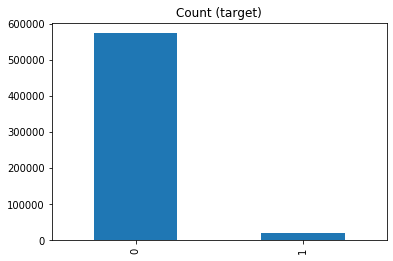

In [28]:
target_count = df.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df.columns[2:]

X = df[labels]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(60, input_dim=57, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,batch_size = 20)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Train on 476169 samples
476169/476169 [==============================] - 25s 53us/sample - loss: 0.1587 - accuracy: 0.9634
Accuracy: 96.36%


In [31]:
model = Sequential()
model.add(Dense(60, input_dim=1, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Train on 476169 samples
476169/476169 [==============================] - 16s 33us/sample - loss: 0.1586 - accuracy: 0.9635
Accuracy: 96.36%


# Confusion matrix
Pulled from lecture 22

In [32]:
import itertools  
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred.round())
class_names = ['0','1']
plt.rcdefaults()
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[114709      0]
 [  4334      0]]


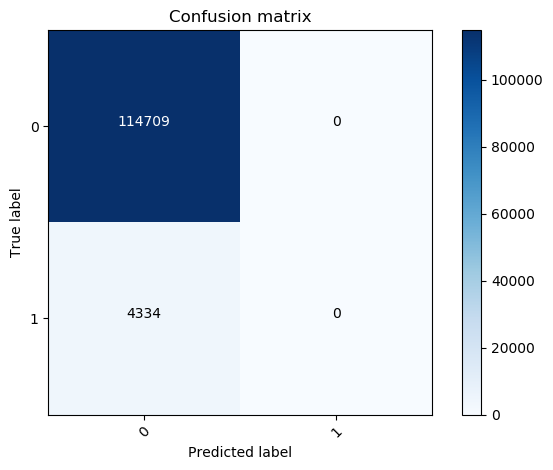

In [33]:
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


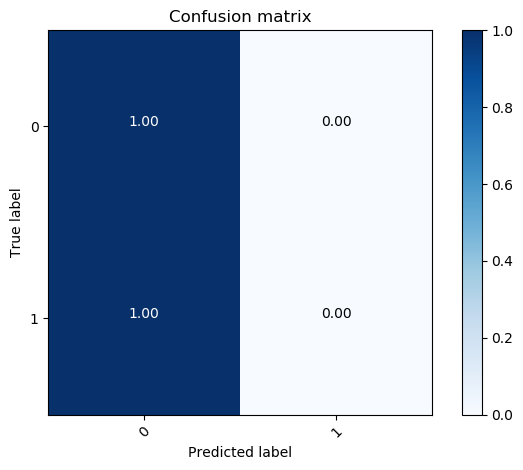

In [34]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')

# Random over-sampling

Random under-sampling:
1    21694
0    21694
Name: target, dtype: int64


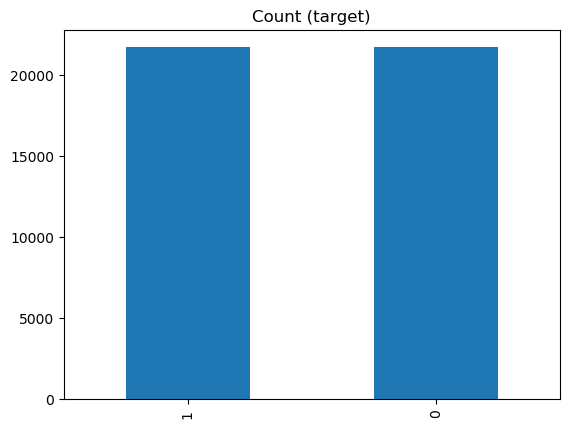

In [35]:
# Class count
count_class_0, count_class_1 = df.target.value_counts()

# Divide by class
df_class_0 = df[df['target'] == 0]
df_class_1 = df[df['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

Train on 34710 samples
34710/34710 [==============================] - 2s 70us/sample - loss: 0.7022 - accuracy: 0.5498
Normalized confusion matrix
[[0.72958836 0.27041164]
 [0.57860313 0.42139687]]
Accuracy: 57.76%


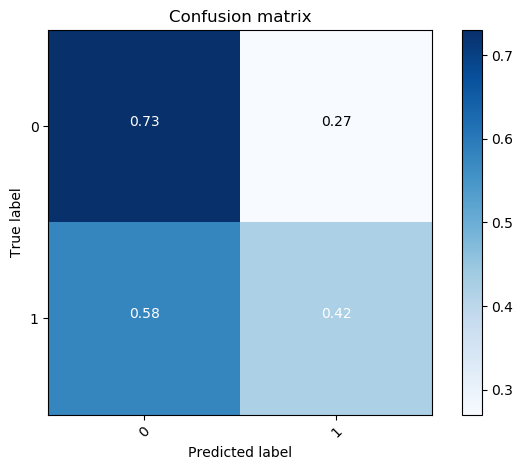

In [49]:
# Remove 'id' and 'target' columns
labels = df.columns[2:]

X = df_test_under[labels]
y = df_test_under['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = Sequential()
model.add(Dense(60, input_dim=57, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')

accuracy = accuracy_score(y_test, y_pred.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Random over-sampling

Random over-sampling:
1    573518
0    573518
Name: target, dtype: int64


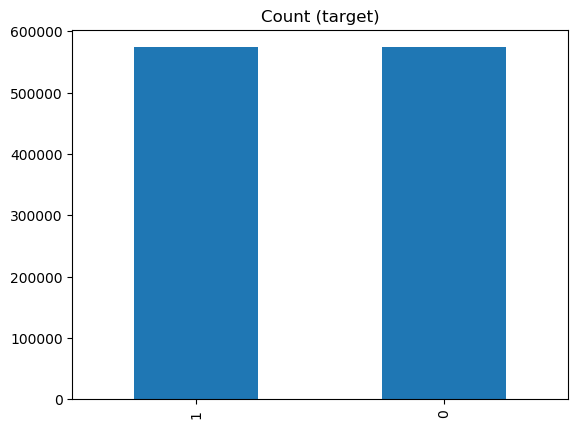

In [50]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

Train on 34710 samples
34710/34710 [==============================] - 2s 47us/sample - loss: 0.7182 - accuracy: 0.5476
Normalized confusion matrix
[[0.56765977 0.43234023]
 [0.4085494  0.5914506 ]]
Accuracy: 57.94%


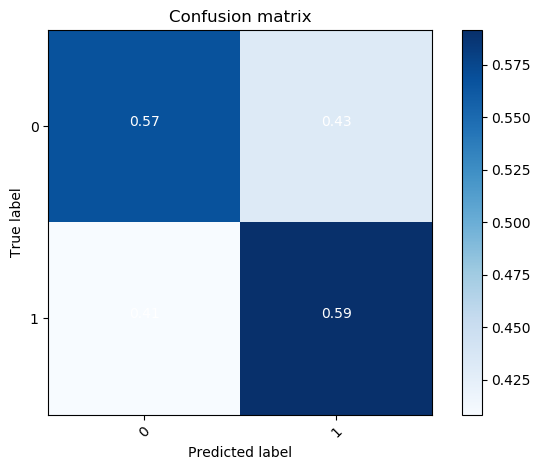

In [51]:
# Remove 'id' and 'target' columns
labels = df.columns[2:]

X = df_test_under[labels]
y = df_test_under['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = Sequential()
model.add(Dense(60, input_dim=57, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')


accuracy = accuracy_score(y_test, y_pred.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# imblearn

In [19]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

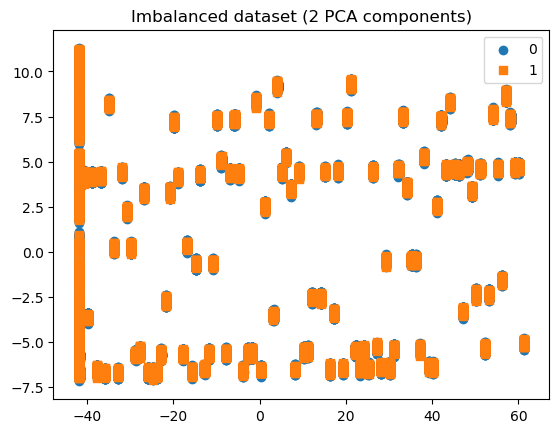

In [16]:
from sklearn.decomposition import PCA

X = df[labels]
y = df['target']

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

# Under-sampling: Tomek links using imblearn 

In [44]:
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df[labels]
y = df['target']

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_sample(X.values, y.values)
id_tl = tl.sample_indices_
print('Removed indexes:', id_tl)

Removed indexes: [     0      1      2 ... 595209 595210 595211]


Train on 588695 samples
588695/588695 [==============================] - 18s 31us/sample - loss: 0.1588 - accuracy: 0.9631
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


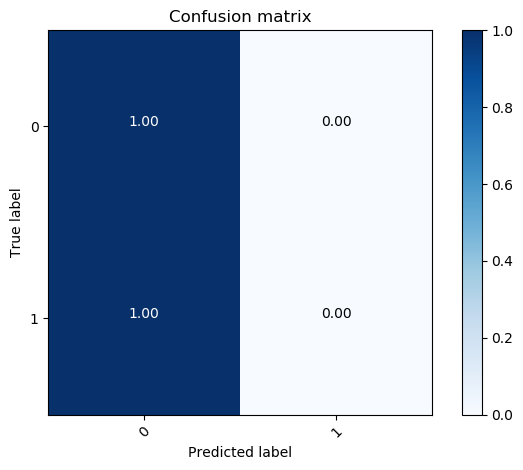

In [45]:
model = models.Sequential()
model.add(layers.Dense(60, input_dim=57, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_tl, y_tl)
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')

# Under-sampling: Cluster Centroids using imblearn

In [42]:
from imblearn.under_sampling import ClusterCentroids
X = df[labels]
y = df['target']

cc = ClusterCentroids(sampling_strategy={0: 10})
X_cc, y_cc = cc.fit_sample(X.values, y.values)

Train on 21704 samples
21704/21704 [==============================] - 1s 51us/sample - loss: 0.0207 - accuracy: 0.9962
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


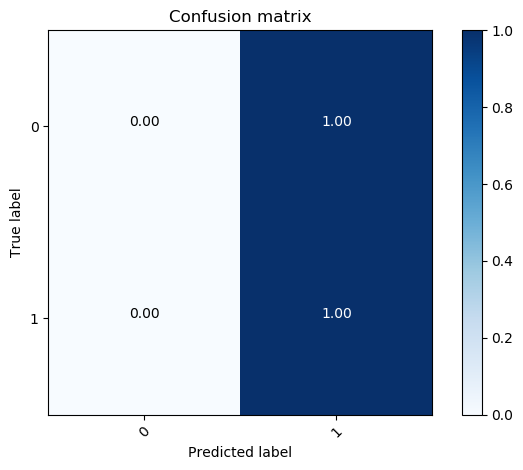

In [43]:
model = models.Sequential()
model.add(layers.Dense(60, input_dim=57, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_cc, y_cc)

y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')

# Over-sampling: SMOTE

In [52]:
from imblearn.over_sampling import SMOTE
X = df[labels]
y = df['target']

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X.values, y.values)

Train on 1147036 samples
1147036/1147036 [==============================] - 40s 35us/sample - loss: 0.5512 - accuracy: 0.7064
Normalized confusion matrix
[[0.85672049 0.14327951]
 [0.81406214 0.18593786]]


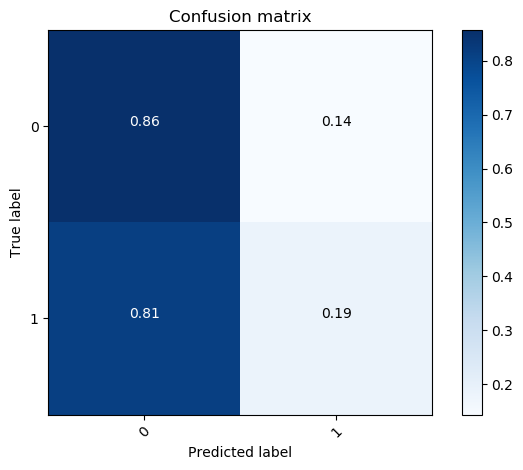

In [53]:
model = models.Sequential()
model.add(layers.Dense(60, input_dim=57, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_sm, y_sm)

y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')

# SMOTE-Tomek

In [46]:
from imblearn.combine import SMOTETomek

X = df[labels]
y = df['target']

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X.values, y.values)

Train on 1147036 samples
1147036/1147036 [==============================] - 35s 30us/sample - loss: 0.5429 - accuracy: 0.7127
Normalized confusion matrix
[[0.87062132 0.12937868]
 [0.24154255 0.75845745]]


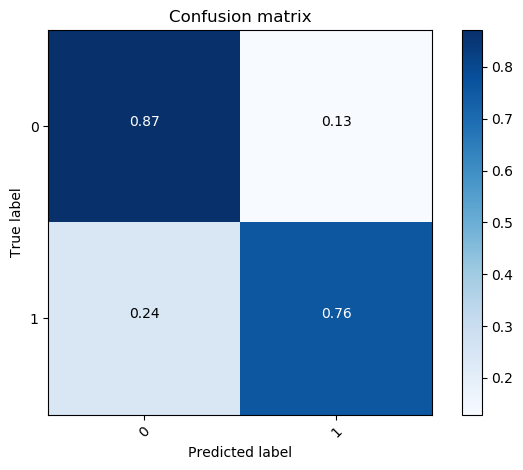

In [47]:
model = models.Sequential()
model.add(layers.Dense(60, input_dim=57, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_smt, y_smt)
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')

# Graph time

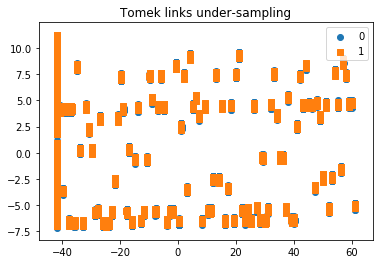

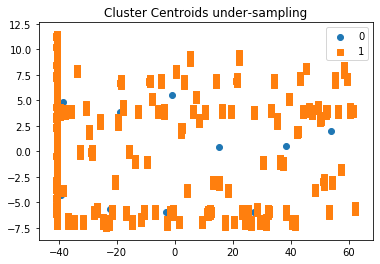

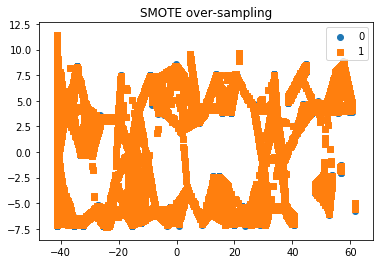

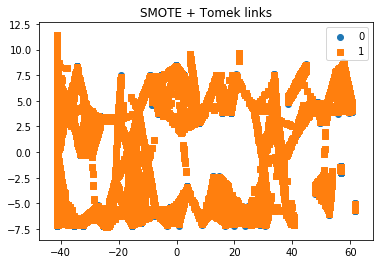

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_tl_PCA = pca.fit_transform(X_tl)
X_cc_PCA = pca.fit_transform(X_cc)
X_sm_PCA = pca.fit_transform(X_sm)
X_smt_PCA = pca.fit_transform(X_smt)


plot_2d_space(X_tl_PCA, y_tl, 'Tomek links under-sampling')
plot_2d_space(X_cc_PCA, y_cc, 'Cluster Centroids under-sampling')
plot_2d_space(X_sm_PCA, y_sm, 'SMOTE over-sampling')
plot_2d_space(X_smt_PCA, y_smt, 'SMOTE + Tomek links')

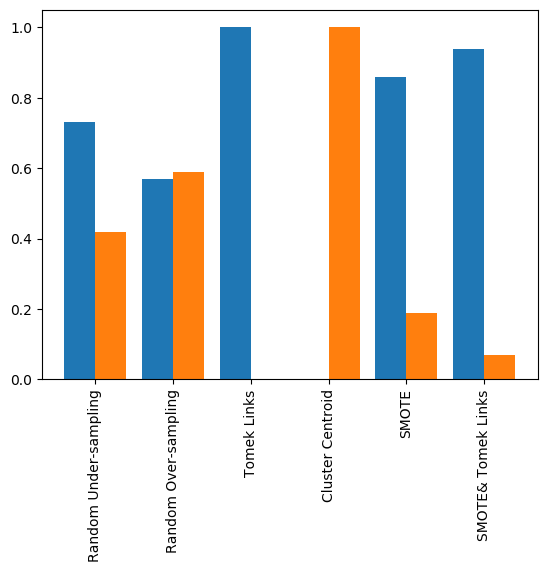

In [54]:
import matplotlib.pyplot as plt
x = [
    'Random Under-sampling',
    'Random Over-sampling',
    'Tomek Links',
    'Cluster Centroid',
    'SMOTE',
    'SMOTE& Tomek Links'
]
_x = np.arange(len(x))
# Accuracy from normalized confusion matrix for the classification of the zero class for each data manipulation method
zeroAcc = [.73, .57, 1, 0, .86, .94]
# Accuracy from normalized confusion matrix for the classificaiton of the one class for each data manipulation method
oneAcc = [.42, .59, 0, 1, .19, .07]
plt.bar(_x - 0.2, zeroAcc, 0.4)
plt.bar(_x + 0.2, oneAcc, 0.4)
plt.xticks(_x, x, rotation='vertical') # set labels manually
plt.show()

# Conclusion

---

The best technique for me was random over-sampling due to its consistancy. It doesn't have the best overall accuracy but it had the most consistent accuracy for zeros and ones. Overall, having an unbalanced dataset sucks. But thanks to imblearn and other packages, it makes it a little better.